In [4]:
%load_ext autoreload
%load_ext watermark
%autoreload 2

# from asampy import cdf
%watermark -mdu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
last updated: 2020-02-15 

compiler   : GCC 7.3.0
system     : Linux
release    : 5.3.0-29-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


[Documentation](https://docs.python.org/3/reference/datamodel.html#invoking-descriptors)  
[How-to](https://docs.python.org/3.7/howto/descriptor.html) from Raymond Hettinger

In general, a descriptor is an object attribute with “binding behavior”, one whose attribute access has been overridden by methods in the descriptor protocol. Those methods are `__get__()`, `__set__()`, and `__delete__()`. If any of those methods are defined for an object, it is said to be a descriptor.

# Descriptors

In [7]:
# Example from how-to:

class RevealAccess(object):
    """A data descriptor that sets and returns values
       normally and prints a message logging their access.
    """

    def __init__(self, initval=None, name='var'):
        self.val = initval
        self.name = name

    def __get__(self, obj, objtype):
        print('Retrieving', self.name)
        return self.val

    def __set__(self, obj, val):
        print('Updating', self.name)
        self.val = val

class MyClass(object):
    x = RevealAccess(10, 'var "x"')
    y = 5

m = MyClass()
m.x
m.x = 20
m.x
m.y

Retrieving var "x"
Updating var "x"
Retrieving var "x"


5

In [12]:
class Trait:
    def __init__(self, minimum, maximum):
        self.minimum = minimum
        self.maximum = maximum

    def __get__(self, instance, owner):
        return instance.__dict__[self.key]

    def __set__(self, instance, value):
        if self.minimum < value < self.maximum:
            instance.__dict__[self.key] = value
        else:
            raise ValueError(f"{value} not in range [{self.minimum};{self.maximum}]")

    def __set_name__(self, owner, name):
        self.key = name
        
class ValidatedContainer:
    att01 = Trait(0, 10)
    att02 = Trait(4, 5)
    
    
# 
c = ValidatedContainer()
c.att01 = 4
try:
    c.att02 = 6
except ValueError as e:
    print(e)

6 not in range [4;5]


## Example (from D. Beazley cookbook, 8-12)

In [6]:
# %load https://github.com/dabeaz/python-cookbook/blob/master/src/8/implementing_a_data_model_or_type_system/example_clsdec.py?raw=True

# Base class. Uses a descriptor to set a value
class Descriptor:
    def __init__(self, name=None, **opts):
        self.name = name
        self.__dict__.update(opts)

    def __set__(self, instance, value):
        instance.__dict__[self.name] = value

# Types definition:
def Typed(expected_type, cls=None):
    if cls is None:
        return lambda cls: Typed(expected_type, cls)

    super_set = cls.__set__
    def __set__(self, instance, value):
        if not isinstance(value, expected_type):
            raise TypeError('expected ' + str(expected_type))
        super_set(self, instance, value)
    cls.__set__ = __set__
    return cls

def Unsigned(cls):
    super_set = cls.__set__
    def __set__(self, instance, value):
        if value < 0:
            raise ValueError('Expected >= 0')
        super_set(self, instance, value)
    cls.__set__ = __set__
    return cls

def MaxSized(cls):
    super_init = cls.__init__
    def __init__(self, name=None, **opts):
        if 'size' not in opts:
            raise TypeError('missing size option')
        self.size = opts['size']
        super_init(self, name, **opts)
    cls.__init__ = __init__

    super_set = cls.__set__
    def __set__(self, instance, value):
        if len(value) >= self.size:
            raise ValueError('size must be < ' + str(self.size))
        super_set(self, instance, value)
    cls.__set__ = __set__
    return cls

In [116]:
@Typed(int)
class Integer(Descriptor):
    pass

@Unsigned
class UnsignedInteger(Integer):
    pass

@Typed(float)
class Float(Descriptor):
    pass

@Unsigned
class UnsignedFloat(Float):
    pass

@Typed(str)
class String(Descriptor):
    pass

@MaxSized
class SizedString(String):
    pass

In [117]:
Float(1.2)

In [35]:
# Testing code
def test(s):
    print(s.name)
    s.shares = 75
    print(s.shares)
    try:
        s.shares = -10
    except ValueError as e:
        print(e)
        
    try:
        s.price = 'a lot'
    except TypeError as e:
        print(e)

    try:
        s.name = 'ABRACADABRA'
    except ValueError as e:
        print(e)

### Test with descriptor

In [32]:
print("# --- Class with descriptors")
class Stock:
    # Specify constraints
    name = SizedString('name', size=8)
    shares = UnsignedInteger('shares')
    price = UnsignedFloat('price')
    def __init__(self, name, shares, price):
        self.name = name
        self.shares = shares
        self.price = price

s = Stock('ACME',50,91.1)
test(s)

### Test with class decorator

In [32]:
# Class decorator to apply constraints
def check_attributes(**kwargs):
    def decorate(cls):
        for key, value in kwargs.items():
            if isinstance(value, Descriptor):
                value.name = key
                setattr(cls, key, value)
            else:
                setattr(cls, key, value(key))
        return cls
    return decorate

@check_attributes(name=SizedString(size=8), 
                  shares=UnsignedInteger,
                  price=UnsignedFloat)
class Stock:
    def __init__(self, name, shares, price):
        self.name = name
        self.shares = shares
        self.price = price

s = Stock('ACME',50,91.1)
test(s)

### Test with metaclass

In [71]:
# A metaclass that applies checking
class checkedmeta(type):
    def __new__(cls, clsname, bases, methods):
        # Attach attribute names to the descriptors
        for key, value in methods.items():
            if isinstance(value, Descriptor):
                value.name = key
        return type.__new__(cls, clsname, bases, methods)


class Stock(metaclass=checkedmeta):
    name   = SizedString(size=8)
    shares = UnsignedInteger()
    price  = UnsignedFloat()
    def __init__(self, name, shares, price):
        self.name = name
        self.shares = shares
        self.price = price

s = Stock('ACAZE', 5, 91.1)
test(s)

ACAZE
75
Expected >= 0
'<' not supported between instances of 'str' and 'int'
size must be < 8


## Usage in a custom container

In [1]:
import xml.etree.ElementTree as ET
import requests
from collections import Sequence
from typing import Dict
import re

In [2]:
# Fetch some data from asam.net and work on a cdfx container 
url = "https://www.asam.net/index.php?eID=dumpFile&t=f&f=203&token=0f5b670d38f303b5e18f13b7e58791b630bac3a4"
f = requests.get(url)
cdfx = f.text

In [186]:
def minus2underscore(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('-', "_")


class SwSystem:
    def __init__(self):
        print("Ajout d'un élément")


# Types definition:
def TypedContainer(expected_type, cls=None):
    if cls is None:
        return lambda cls: TypedContainer(expected_type, cls)

    super_append = cls.append
    def append(self, elt):
        if not isinstance(elt, expected_type):
            raise TypeError('expected ' + str(expected_type))
        super_append(self, elt)
    cls.append = append
    return cls


@TypedContainer(SwSystem)
class SwSystems(Sequence):
    def __init__(self):
        self._items = []
    def __getitem__(self, index):
        return self._items[index]
    def append(self, elt):
        self._items.append(elt)
    def __len__(self):
        return len(self._items)

    
class MSRSW(metaclass=checkedmeta):
    """
    <MSRSW> is the root element, which may contains a short name (<SHORT-NAME>)
    and a category (<CATEGORY>). The category value indicates the standard and
    version number, e.g. the value "CDF20" denotes ASAM CDF V2.0.
    """
    short_name = String()
    category = String()
    sw_systems: Dict[str, SwSystem] = SwSystems()

    def __init__(self, elt):
        for node in elt:
            if len(node) == 0:
                setattr(self, minus2underscore(node.tag), node.text)
        for swsystem in elt.iter("SW-SYSTEM"):
            self.sw_systems.append(SwSystem())

In [187]:
root = ET.fromstring(cdfx)
msrsw = MSRSW(root)

Ajout d'un élément


In [178]:
elt = msrsw.sw_systems[0]

In [4]:
from asampy import cdf

TypeError: non-default argument 'sw_axis_conts' follows default argument

In [5]:
cdfx = cdf.cdfx(root)

NameError: name 'cdf' is not defined

In [196]:
swsystem = cdfx.msrsw.sw_systems[0]

In [208]:
swinstance = swsystem.sw_instance_spec.sw_instance_tree.sw_instance

In [219]:
cdfx['ASAM.C.CURVE.FIX_AXIS.PAR_DIST']

<xarray.DataArray (dim_0: 6)>
array([-10., -11., -12., -10.,  -9., -11.])
Coordinates:
  * dim_0    (dim_0) float64 1.0 2.0 3.0 4.0 5.0 6.0

In [181]:

msrsw.sw_systems.append(SwSystem())

Ajout d'un élément


In [214]:
cdfx.res

{'ASAM.C.CURVE.FIX_AXIS.PAR': <xarray.DataArray (dim_0: 6)>
 array([9., 8., 7., 8., 9., 5.])
 Coordinates:
   * dim_0    (dim_0) float64 0.0 4.0 8.0 12.0 16.0 20.0,
 'ASAM.C.CURVE.FIX_AXIS.PAR_DIST': <xarray.DataArray (dim_0: 6)>
 array([-10., -11., -12., -10.,  -9., -11.])
 Coordinates:
   * dim_0    (dim_0) float64 1.0 2.0 3.0 4.0 5.0 6.0,
 'ASAM.C.CURVE.FIX_AXIS.PAR_LIST': <xarray.DataArray (dim_0: 6)>
 array([2., 3., 4., 2., 4., 3.])
 Coordinates:
   * dim_0    (dim_0) float64 -1.0 4.0 6.0 8.0 9.0 10.0,
 'ASAM.C.CURVE.STD_AXIS': <xarray.DataArray (dim_0: 8)>
 array([-3., -1.,  6.,  5.,  9.,  9., 13.,  9.])
 Coordinates:
   * dim_0    (dim_0) float64 -5.0 -1.0 2.0 4.0 5.0 8.0 14.0 22.0,
 'ASAM.C.CURVE.STD_AXIS.MONOTONY_STRICT_DECREASE': <xarray.DataArray (dim_0: 8)>
 array([2708.,  759.,  690., 2141.,  690., 1657., 1312.,  -56.])
 Coordinates:
   * dim_0    (dim_0) float64 5.0 3.0 1.0 -1.0 -3.0 -5.0 -7.0 -9.0,
 'ASAM.C.CURVE.STD_AXIS.MONOTONY_STRICT_INCREASE': <xarray.DataArray (dim

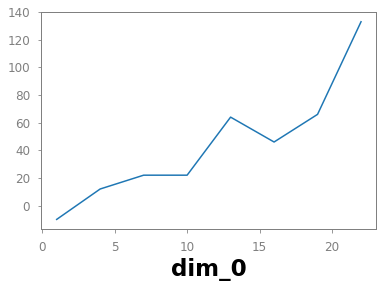

In [216]:
cdfx.res['ASAM.C.CURVE.STD_AXIS.MONOTONY_STRICT_INCREASE'].plot()

In [183]:
msrsw.sw_systems[1]

In [141]:
# Base class. Uses a descriptor to set a value
class Descriptor:
    def __init__(self, name=None, **opts):
        self.name = name
        self.__dict__.update(opts)

    def __set__(self, instance, value):
        instance.__dict__[self.name] = value

